In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [4]:
train ={1:{
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                },
                2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                }
                }
test = {6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                }}
appliances = ["Refrigerator"]

In [5]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler


def dataset_load(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    n = 99
    units_to_pad = n // 2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    # train
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_train.extend(x)
        y_train.extend(y)
        x_train_timestamp.extend(torch.tensor(timestamp_train))


    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)


    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    x_test_timestamp_true =[]
    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp_true = df["Timestamp"].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_test.extend(x)
        y_test.extend(y)
        x_test_timestamp_true.extend(timestamp_true)
        x_test_timestamp.extend(timestamp)

    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
#     y_test = scaler_y.transform(y_test)

    x_train = jnp.array(x_train).reshape(x_train.shape[0], n, 1)
    y_train = jnp.array(y_train)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test).reshape(x_test.shape[0], n, 1)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float64)

    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, x_test_timestamp_true, scaler_x, scaler_y, scaler_time


In [6]:
x_train, y_train, x_test, y_test, x_train_timstamp, x_test_timestamp, test_timestamp_orig, scaler_x, scaler_y, scaler_time = dataset_load(appliances, train, test)

In [7]:
n = 99
x_train_full = jnp.concatenate((x_train.reshape(-1,n), jnp.array(np.array(x_train_timstamp))), axis=1)
x_test_full = jnp.concatenate((x_test.reshape(-1,n), jnp.array(np.array(x_test_timestamp))), axis=1)
x_train_full.shape, x_test_full.shape

((53456, 100), (16781, 100))

In [8]:
x_train.reshape(-1,n).shape, x_test.reshape(-1,n).shape, y_train.shape, y_test.shape

((53456, 99), (16781, 99), (53456, 1), (16781, 1))

In [9]:
# x = x_train_full[:14000]
# y = y_train[:14000]
# xt = x_train_full[14000:]
# yt = y_train[14000:]

In [10]:
# x.shape, y.shape

In [11]:
indexes = 53456
x = torch.tensor(np.array(x_train.reshape(-1,n))).to(torch.float64)
y = torch.tensor(np.array(y_train)).reshape(-1,).to(torch.float64)
xt = torch.tensor(np.array(x_test.reshape(-1,n))).to(torch.float64)
yt = torch.tensor(np.array(y_test)).reshape(-1,).to(torch.float64)

if x.shape[0]>indexes:
  x1 = x[:indexes]
  y1 = y[:indexes]

# xt = xt[:16000]
# yt = yt[:16000]

In [12]:
x.dtype

torch.float64

In [13]:
x.shape, y.shape, xt.shape, yt.shape

(torch.Size([53456, 99]),
 torch.Size([53456]),
 torch.Size([16781, 99]),
 torch.Size([16781]))

restart: 0, epoch: 1, iter: 1, loss: 1.4434
restart: 0, epoch: 2, iter: 1, loss: 1.4243
restart: 0, epoch: 3, iter: 1, loss: 1.4099


/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


restart: 0, epoch: 4, iter: 1, loss: 1.3980
restart: 0, epoch: 5, iter: 1, loss: 1.3879
restart: 0, epoch: 6, iter: 1, loss: 1.3790
restart: 0, epoch: 7, iter: 1, loss: 1.3710
restart: 0, epoch: 8, iter: 1, loss: 1.3638
restart: 0, epoch: 9, iter: 1, loss: 1.3572
restart: 0, epoch: 10, iter: 1, loss: 1.3510
restart: 0, epoch: 11, iter: 1, loss: 1.3453
restart: 0, epoch: 12, iter: 1, loss: 1.3399
restart: 0, epoch: 13, iter: 1, loss: 1.3348
restart: 0, epoch: 14, iter: 1, loss: 1.3300
restart: 0, epoch: 15, iter: 1, loss: 1.3254
restart: 0, epoch: 16, iter: 1, loss: 1.3211
restart: 0, epoch: 17, iter: 1, loss: 1.3169
restart: 0, epoch: 18, iter: 1, loss: 1.3128
restart: 0, epoch: 19, iter: 1, loss: 1.3089
restart: 0, epoch: 20, iter: 1, loss: 1.3051
restart: 0, epoch: 21, iter: 1, loss: 1.3015
restart: 0, epoch: 22, iter: 1, loss: 1.2979
restart: 0, epoch: 23, iter: 1, loss: 1.2945
restart: 0, epoch: 24, iter: 1, loss: 1.2911
restart: 0, epoch: 25, iter: 1, loss: 1.2878
restart: 0, epoc

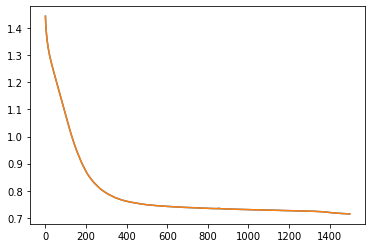

In [18]:
mae_arr =[]
rms_arr = []
y_pred_arr = []

batch = 512

# x_train = x_train[:4500]
# y_train = y_train[:4500]

# y_test_trans = torch.tensor(torch.tensor(scaler_x.transform(y_test.reshape(-1,1))).reshape(-1,)).contiguous().to(torch.float64)
for i in range(2):


   #nu=2.5,

  kernel1 = ScaleKernel(RBFKernel(ard_num_dims=n))
  # kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1,active_dims=(99)))
  # kernel3 = ScaleKernel(CosineKernel(ard_num_dims=1,active_dims=(99)))

  # kernel4 = kernel2*kernel3
  kernel = kernel1 #+ kernel4
  # induce_points = 512
  inducing_points =  x[np.arange(0,x.shape[0],70)] 
  # inducing_points = x[torch.randperm(x.shape[0])[: 1500]]
  
  model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                       inducing_points).to("cuda")
  # model.base_covar_module.base_kernel.raw_lengthscale_constraint
  # model.mll.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-2))
  # for param in model.parameters():
  #   # print(param)
  #   torch.nn.init.normal_(param, 0, 1)
  # theta1 = {'likelihood.noise_covar.noise': torch.tensor(3),
  #       'covar_module.base_kernel.lengthscale': torch.tensor(0.1),
  #       'covar_module.outputscale': torch.tensor(5),}
  loss = model.fit(lr=0.01, n_epochs=1500,verbose=2,
          random_state=0, n_restarts=1)
#   loss_arr.append(loss)
  # print(loss)
  plt.plot(np.asarray(loss[0]))
  # plt.plot(np.asarray(test_loss[0]))

  model_name = "Refrigerator_rbf_building6_" + str(i) + ".pt"
  torch.save(model.state_dict(), os.path.join(
   "./final_models/", model_name))






  # y_pred_arr.append(pred_dist.loc)

  

In [15]:
model_name = "Refrigerator_rbf_building3_trial_per8rbf.pt"
torch.save(model.state_dict(), os.path.join(
   "./final_models/", model_name))

## Decomp

In [14]:
pred_arr =[]

In [18]:
kernel1 = ScaleKernel(RBFKernel(ard_num_dims=n))
# kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1,active_dims=(99)))
# kernel3 = ScaleKernel(CosineKernel(ard_num_dims=1,active_dims=(99)))

# kernel4 = kernel2*kernel3
kernel = kernel1 #ernel4
# induce_points = 512
inducing_points =  x[np.arange(0,x.shape[0],70)] 
# inducing_points = x[torch.randperm(x.shape[0])[: 1500]]

model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                      inducing_points).to("cuda")

model_name =  "Refrigerator_rbf_building6_" + str(0) + ".pt"
model.load_state_dict(torch.load(
    os.path.join("./final_models/", model_name)))

<All keys matched successfully>

In [19]:
pred_dist1 = model.predict(xt[:4000].to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

In [26]:
y_mean1.shape

torch.Size([4000])

In [20]:
pred_arr.append(np.array(pred_dist1.mean.cpu()))

In [33]:
pred_arr

[array([1.21238626, 1.41398948, 1.37901014, ..., 1.09691403, 1.06159951,
        1.03337154]),
 array([1.21238626, 1.41398948, 1.37901014, ..., 1.09691403, 1.06159951,
        1.03337154])]

In [36]:
y_mean = np.mean(pred_arr, axis =0)
y_Std = np.std(np.array(pred_arr), axis =0)

In [37]:
y_mean.shape, y_Std.shape

((4000,), (4000,))

In [38]:
y_mean = scaler_y.inverse_transform(y_mean.reshape(-1,1)).squeeze()
y_std = scaler_y.inverse_transform(y_Std.reshape(-1,1)).squeeze()

In [39]:
y_mean.shape

(4000,)

In [48]:
y_mean.any() < 0

False

In [73]:
y_mean_ = np.clip(y_mean,0,y_mean.max())
y_sigma =  np.clip(y_mean,0,y_mean.max())

saving image to ./Final_plotss/Uncertainity_latexified.pdf
Figure size: [3. 2.]


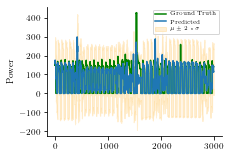

In [78]:
idx = 3000
# plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), yt.cpu()[:idx], label = "Ground Truth", color="green")
plt.plot(jnp.arange(idx), y_mean_[:idx].reshape(-1,1), label = "Predicted")
for i in range(2,3):
    plt.fill_between(jnp.arange(idx), y_mean[:idx] - i*y_std[:idx], y_mean[:idx] + i*y_std[:idx],
                    color="orange", alpha=(1/(i*3)), label=f"$\mu\pm{i}*\sigma$")
# plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.legend( prop={'size': 5.5})
plt.ylabel("Power")
sns.despine()
savefig("Uncertainity")

In [19]:
scaler_y.inverse_transform(y_mean1.cpu().reshape(-1,1)).squeeze()

array([159.52542063, 175.96384957, 173.11168549, ...,  91.2025745 ,
       104.93473154, 107.42363777])

In [20]:
y_mean = scaler_y.inverse_transform(y_mean2.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean.shape)

torch.Size([16781]) (16781,)


In [25]:
y_mean2

tensor([1.2124, 1.4140, 1.3790,  ..., 0.3745, 0.5429, 0.5734], device='cuda:0',
       dtype=torch.float64)

In [28]:
import csv

# open the file in the write mode
f = open('results1.csv', 'w')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(y_mean2)

# close the file
f.close()

In [26]:
f = open('results1.csv', 'r')
reder = csv.reader(f)

i = 0
for row in reder:
  # if line_count == 0:
   ym = row
   break

In [27]:
ym

["tensor(1.2124, device='cuda:0', dtype=torch.float64)",
 "tensor(1.4140, device='cuda:0', dtype=torch.float64)",
 "tensor(1.3790, device='cuda:0', dtype=torch.float64)",
 "tensor(1.2910, device='cuda:0', dtype=torch.float64)",
 "tensor(1.2548, device='cuda:0', dtype=torch.float64)",
 "tensor(1.1999, device='cuda:0', dtype=torch.float64)",
 "tensor(1.1467, device='cuda:0', dtype=torch.float64)",
 "tensor(1.1430, device='cuda:0', dtype=torch.float64)",
 "tensor(1.1403, device='cuda:0', dtype=torch.float64)",
 "tensor(1.1553, device='cuda:0', dtype=torch.float64)",
 "tensor(1.1714, device='cuda:0', dtype=torch.float64)",
 "tensor(1.1683, device='cuda:0', dtype=torch.float64)",
 "tensor(1.0861, device='cuda:0', dtype=torch.float64)",
 "tensor(1.1100, device='cuda:0', dtype=torch.float64)",
 "tensor(0.3152, device='cuda:0', dtype=torch.float64)",
 "tensor(0.2190, device='cuda:0', dtype=torch.float64)",
 "tensor(0.2945, device='cuda:0', dtype=torch.float64)",
 "tensor(0.2974, device='cuda:0

In [22]:
mae = np.mean(np.abs(np.array(yt) - y_mean))
rms = errors.rmse(jnp.array(yt), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  27.80521506352558
RMSE:  44.84471


In [59]:
try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled


In [60]:
os.environ["LATEXIFY"] = "1"
os.environ["FIG_DIR"] = "./Final_plotss/"

In [62]:
latexify(width_scale_factor=2, fig_height=2)

In [22]:
idx = 2000
# plt.figure(figsize=(10,6))
plt.figure()
plt.plot(jnp.arange(idx), yt[300:idx+300], label = "Fridge True")
plt.plot(jnp.arange(idx), y_mean[300:idx+300], label = "Fridge Predicted")
plt.legend()
sns.despine()
savefig("CombinationKernel")

saving image to ./Final_plotss/CombinationKernel_latexified.pdf
Figure size: [2. 2.]


In [23]:
model1 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel1,
                       inducing_points).to("cuda")

In [24]:
pred_dist1 = model1.predict(xt.to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

In [25]:
y_mean1 = scaler_y.inverse_transform(y_mean1.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean1.shape)

torch.Size([14780]) (14780,)


In [26]:
idx = 2000
# plt.figure(figsize=(10,6))
plt.figure()
plt.plot(jnp.arange(idx), yt[300:idx+300], label = "Fridge True")
plt.plot(jnp.arange(idx), y_mean1[300:idx+300], label = "Fridge Predicted")
# plt.legend()
sns.despine()
savefig("RBFKernel")

saving image to ./Final_plotss/RBFKernel_latexified.pdf
Figure size: [2. 2.]


In [ ]:
# for name, params in model.named_parameters():
#   print(name, params)

# # model.mll.model.base_covar_module.kernels.base_kernel.raw_lengthscale

In [19]:
x.shape

torch.Size([55457, 100])

In [22]:
model2 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel4,
                       inducing_points).to("cuda")

In [23]:
pred_dist2 = model2.predict(xt.to("cuda"))
# print("Done ", i)

y_mean2 = pred_dist2.loc

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


In [24]:
y_mean2 = scaler_y.inverse_transform(y_mean2.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean2.shape)

torch.Size([14780]) (14780,)


In [26]:
idx = 2000
plt.figure()
# plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), yt[300:idx+300], label = "Fridge True")
plt.plot(jnp.arange(idx), y_mean2[300:idx+300], label = "Fridge Predicted")
# plt.legend()
sns.despine()
savefig("RBFxPeriodicKernel")

saving image to ./Final_plotss/RBFxPeriodicKernel_latexified.pdf
Figure size: [2. 2.]


## Normal

In [14]:
kernel1 = ScaleKernel(RBFKernel(ard_num_dims=n+1))
kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1,active_dims=(99)))
kernel3 = ScaleKernel(CosineKernel(ard_num_dims=1,active_dims=(99)))

kernel4 = kernel2*kernel3
kernel = kernel1 + kernel4
# induce_points = 512
inducing_points =  x[np.arange(0,x.shape[0],70)] 
# inducing_points = x[torch.randperm(x.shape[0])[: 1500]]

model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                      inducing_points).to("cuda")

model_name =  "Refrigerator_rbf_building1_trial_per8rbf.pt"
model.load_state_dict(torch.load(
    os.path.join("./final_models/", model_name)))

<All keys matched successfully>

In [ ]:
for name, params in model.named_parameters():
  print(name, params)

mll.likelihood.noise_covar.raw_noise Parameter containing:
tensor([-1.5588], device='cuda:0', requires_grad=True)
mll.model.mean_module.constant Parameter containing:
tensor([0.0292], device='cuda:0', requires_grad=True)
mll.model.base_covar_module.raw_outputscale Parameter containing:
tensor(-1.7130, device='cuda:0', requires_grad=True)
mll.model.base_covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[ 3.8248,  4.4983,  4.7307,  4.8950,  4.9043,  5.0083,  4.8669,  4.9300,
          4.3008,  4.5551,  4.9983,  5.1306,  5.1432,  5.2098,  5.2786,  5.2542,
          5.1909,  5.0685,  5.1152,  4.8119,  4.6334,  4.8655,  4.7442, -0.7551,
          4.4712,  4.9479,  5.0614,  5.2808,  4.9541,  5.1342,  5.2077,  4.4659,
          4.5550,  4.5581,  3.8090,  3.0422,  2.7183,  4.0780,  4.0222,  4.6081,
          4.5821,  4.4903,  4.0346,  4.8344,  5.2088,  5.3975,  4.7938,  4.4909,
         -0.0621, -2.0145,  1.0874,  4.8745,  4.6688,  4.8475,  4.5114,  4.5462,
          5.010

In [35]:
import numpy as np
try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled


os.environ["LATEXIFY"] = "1"
os.environ["FIG_DIR"] = "./Final_plotss/"

latexify(width_scale_factor=2, fig_height=2)


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
arr = np.array([3.8464, 4.5094, 4.7394, 4.9024, 4.9117, 5.0150, 4.8746, 4.9372, 4.3143,
         4.5656, 5.0050, 5.1365, 5.1490, 5.2152, 5.2837, 5.2594, 5.1965, 5.0747,
         5.1212, 4.8200, 4.6431, 4.8732, 4.7529, 0.3853, 4.4826, 4.9550, 5.0677,
         5.2859, 4.9612, 5.1401, 5.2131, 4.4774, 4.5654, 4.5685, 3.8310, 3.0889,
         2.7822, 4.0948, 4.0399, 4.6180, 4.5923, 4.5015, 4.0521, 4.8423, 5.2143,
         5.4020, 4.8021, 4.5021, 0.6626, 0.1252, 1.3779, 4.8821, 4.6781, 4.8554,
         4.5223, 4.5568, 5.0172, 5.4072, 5.0706, 4.5916, 4.5663, 4.1121, 4.2572,
         4.2228, 3.7784, 0.4839, 3.6554, 4.3523, 4.6682, 4.6549, 4.8291, 5.0260,
         4.7748, 4.5609, 4.4541, 4.4165, 4.4292, 4.1279, 3.6382, 4.1110, 4.7252,
         5.0184, 5.0391, 5.2424, 5.5062, 5.4739, 5.5326, 5.6874, 5.6897, 5.4765,
         5.4602, 5.4513, 5.5450, 5.6225, 5.5479, 5.3580, 5.3926, 5.1536, 4.6321])
ar1 = np.arange(0,99,1)
plt.plot(ar1,arr,'b')
plt.xlabel('ARD')
plt.ylabel('Learned ARD LengthScale values')
# plt.title("Building 6 Test")

plt.show()
sns.despine()
savefig("ARD_Ref")


saving image to ./Final_plotss/ARD_Ref_latexified.pdf
Figure size: [2. 2.]


In [17]:
pred_dist = model.predict(xt.to("cuda"))
# print("Done ", i)

y_mean = pred_dist.loc

In [18]:
y_mean = scaler_y.inverse_transform(y_mean.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean.shape)

torch.Size([14780]) (14780,)


In [19]:
mae = np.mean(np.abs(np.array(yt) - y_mean))
rms = errors.rmse(jnp.array(yt), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  30.33380341263335
RMSE:  47.134686


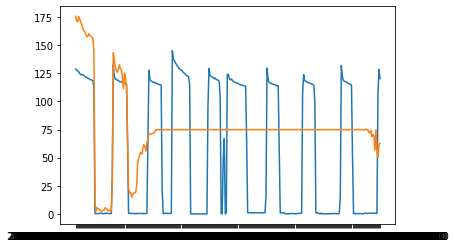

In [ ]:
# plt.plot(np.array(test_timestamp_orig)[:300],np.array(yt)[:300])
# plt.plot(np.array(test_timestamp_orig)[:300],np.array(y_mean)[:300])

In [ ]:
# test_timestamp_orig

['2011-04-21 00:00:00-04:00',
 '2011-04-21 00:01:00-04:00',
 '2011-04-21 00:02:00-04:00',
 '2011-04-21 00:03:00-04:00',
 '2011-04-21 00:04:00-04:00',
 '2011-04-21 00:05:00-04:00',
 '2011-04-21 00:06:00-04:00',
 '2011-04-21 00:07:00-04:00',
 '2011-04-21 00:08:00-04:00',
 '2011-04-21 00:09:00-04:00',
 '2011-04-21 00:10:00-04:00',
 '2011-04-21 00:11:00-04:00',
 '2011-04-21 00:12:00-04:00',
 '2011-04-21 00:13:00-04:00',
 '2011-04-21 00:14:00-04:00',
 '2011-04-21 00:15:00-04:00',
 '2011-04-21 00:16:00-04:00',
 '2011-04-21 00:17:00-04:00',
 '2011-04-21 00:18:00-04:00',
 '2011-04-21 00:19:00-04:00',
 '2011-04-21 00:20:00-04:00',
 '2011-04-21 00:21:00-04:00',
 '2011-04-21 00:22:00-04:00',
 '2011-04-21 00:23:00-04:00',
 '2011-04-21 00:24:00-04:00',
 '2011-04-21 00:25:00-04:00',
 '2011-04-21 00:26:00-04:00',
 '2011-04-21 00:27:00-04:00',
 '2011-04-21 00:28:00-04:00',
 '2011-04-21 00:29:00-04:00',
 '2011-04-21 00:30:00-04:00',
 '2011-04-21 00:31:00-04:00',
 '2011-04-21 00:32:00-04:00',
 '2011-04-

In [ ]:
# plt.scatter(np.array(test_timestamp_orig)[:3000],np.array(y_mean)[:3000],label="True")
# plt.scatter(np.array(test_timestamp_orig)[:3000],np.array(yt)[:3000],label="Pred")
# plt.legend()
# plt.xlabel("TimeStamp")
# plt.xlabel("Refrogerator Power")

Text(0.5, 0, 'Refrogerator Power')

Error in callback <function flush_figures at 0x7f8f0b1b2ef0> (for post_execute):


KeyboardInterrupt: 

saving image to ./Final_plotss/CombinationKernel_latexified.pdf
Figure size: [3. 2.]


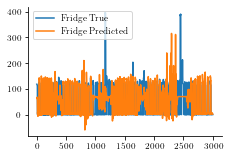

In [36]:
idx = 3000
# plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), yt[300:idx+300], label = "Fridge True")
plt.plot(jnp.arange(idx), y_mean[300:idx+300], label = "Fridge Predicted")
plt.legend()
sns.despine()
savefig("CombinationKernel")
# plt.savefig("./Results/Refrigerator_building5.png", bbox_inches="tight")

In [27]:
model1 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel1,
                      inducing_points).to("cuda")

In [28]:
pred_dist1 = model1.predict(xt.to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

RuntimeError: CUDA out of memory. Tried to allocate 1.63 GiB (GPU 0; 79.17 GiB total capacity; 4.89 GiB already allocated; 778.38 MiB free; 6.01 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
#MAE:  39.81858310475401 build 6
#MAE:  30.333733374869247 build 3
#MAE:  37.32115756605644 build 2
#MAE: 43.212248588857065 build 5
#MAE:  48.917852990726765